In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [ ]:
data = [
    ("i love you", "je t aime"),
    ("he is nice", "il est gentil"),
    ("she is kind", "elle est gentille"),
    ("they play football", "ils jouent au football"),
]

src_vocab = {"<pad>":0, "<sos>":1, "<eos>":2}
tgt_vocab = {"<pad>":0, "<sos>":1, "<eos>":2}

In [3]:
for s, t in data:
    for w in s.split():
        if w not in src_vocab:
            src_vocab[w] = len(src_vocab)
    for w in t.split():
        if w not in tgt_vocab:
            tgt_vocab[w] = len(tgt_vocab)

src_idx2word = {v:k for k,v in src_vocab.items()}
tgt_idx2word = {v:k for k,v in tgt_vocab.items()}

def encode(sentence, vocab):
    return [vocab["<sos>"]] + [vocab[w] for w in sentence.split()] + [vocab["<eos>"]]

pairs = [(encode(s, src_vocab), encode(t, tgt_vocab)) for s,t in data]

In [4]:
class TranslationDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        return torch.tensor(src), torch.tensor(tgt)

dataset = TranslationDataset(pairs)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [5]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=128, nhead=8, num_layers=2):
        super().__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoder = nn.Sequential(
            nn.Dropout(0.1)
        )
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead, num_encoder_layers=num_layers,
            num_decoder_layers=num_layers, dim_feedforward=256
        )
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt):
        src = self.src_emb(src).permute(1,0,2)  # (S, N, E)
        tgt = self.tgt_emb(tgt).permute(1,0,2)
        output = self.transformer(src, tgt)
        return self.fc_out(output).permute(1,0,2)  # (N, S, V)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TransformerModel(len(src_vocab), len(tgt_vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 200
loss_history = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for src, tgt in loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])  # shift right
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: loss = {avg_loss:.4f}")


d:\Python\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0: loss = 2.8209
Epoch 20: loss = 0.0268
Epoch 40: loss = 0.0118
Epoch 60: loss = 0.0081
Epoch 80: loss = 0.0057
Epoch 100: loss = 0.0038
Epoch 120: loss = 0.0032
Epoch 140: loss = 0.0026
Epoch 160: loss = 0.0020
Epoch 180: loss = 0.0015


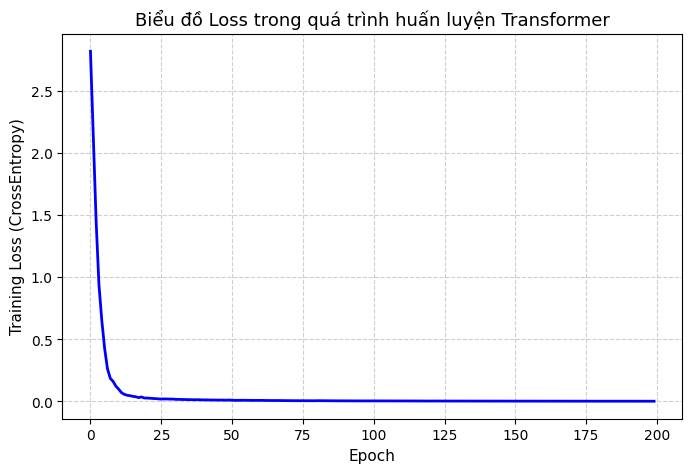

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(loss_history, color='blue', linewidth=2)
plt.title("Biểu đồ Loss trong quá trình huấn luyện Transformer", fontsize=13)
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Training Loss (CrossEntropy)", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [8]:
def translate(sentence):
    model.eval()
    src = torch.tensor(encode(sentence, src_vocab)).unsqueeze(0).to(device)
    tgt = torch.tensor([tgt_vocab["<sos>"]]).unsqueeze(0).to(device)

    for _ in range(10):
        output = model(src, tgt)
        next_token = output[:, -1, :].argmax(-1).unsqueeze(0)
        tgt = torch.cat((tgt, next_token), dim=1)
        if next_token.item() == tgt_vocab["<eos>"]:
            break
    return " ".join([tgt_idx2word[idx.item()] for idx in tgt[0]])

print(translate("i love you"))

<sos> je t aime <eos>
